In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
from scipy.sparse.linalg import bicgstab, bicg, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk
import matplotlib.animation as animation
from IPython.display import HTML

import time
start_time = time.time()
%matplotlib inline

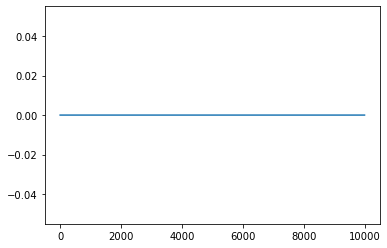

In [2]:
Nx = 10000
Lx = 1000
dx = Lx/(Nx-1)
cfl = 1
T = 100
Nprint = 1000
dt_print = T/Nprint
mu_lim = 0.4
lbda = .3
Temp = 10
sqrtTemp = np.sqrt(Temp)
B = .5
F0 = .8
f0 = 1

def f(c):
    return c
R = Lx/40

X = np.linspace(0,Lx,Nx)
mu0 = np.zeros(Nx)
mu0[np.abs(X-Lx/2)<R]=0.01
u0 = np.zeros(Nx)
#v0 = np.zeros(Nx)
rho0 = np.zeros(Nx)
C0 = np.full((Nx),f0)

def F(*args):
    return F0
plt.plot(rho0)

In [3]:
def primal(mu,impx):
    eps = 1e-9
    u = np.zeros(Nx)
    tarray = (mu>eps)
    u[tarray]= impx[tarray]/mu[tarray]
    mu[np.logical_not(tarray)] = 0
    impx = u*mu
    return mu,u,impx

def fnum_x(h,mu,impx):
    #Remise dans les variables primales
    mu,u,impx = primal(mu,impx)
    fmu = np.zeros(Nx)
    fimpx = np.zeros(Nx)
    #Initialisation aux variables centrees
    mug = np.roll(mu,1)
    impxg = np.roll(impx,1)
    ug = np.roll(u,1)
    #Moyenne de Roe
    uc = np.zeros(Nx)
    tarray = (np.sqrt(mu)+np.sqrt(mug)>0)
    uc[tarray] = (np.sqrt(mu[tarray])*u[tarray]+np.sqrt(mug[tarray])*ug[tarray])/ \
        (np.sqrt(mu[tarray])+np.sqrt(mug[tarray]))
    #Calcul des valeurs propres
    l1 = uc + sqrtTemp*np.ones(Nx)
    l2 = uc - sqrtTemp*np.ones(Nx)
    l3 = uc
    #Decentrement amont pour chacun des invariants de Riemann
    #Wave strengths
    r1 = (-(mu-mug)*l2+(impx-impxg))/(2*sqrtTemp)
    r2 = ((mu-mug)*l1-(impx-impxg))/(2*sqrtTemp)
    r1 = np.abs(l1)*r1
    r2 = np.abs(l2)*r2
    #Calcul des flux
    fmu = 0.5*(impx+impxg - (r1+r2))
    fimpx = 0.5*(impx*u+Temp*mu+impxg*ug+Temp*mug - (r1*l1 + r2*l2))
    return fmu, fimpx

def solve_adv_x(h,mu,impx):
    fmu, fimpx = fnum_x(h,mu,impx)
    #Mise a jour des valeurs
    mu += h/dx*(fmu-np.roll(fmu,-1))
    impx += h/dx*(fimpx-np.roll(fimpx,-1))
    mu,u,impx = primal(mu,impx)
    return mu,impx,u

In [4]:
def find_first(test):
    try:
        ans = np.min(X[test])
    except:
        ans = Nx+1
    
    return ans

In [5]:
test = np.zeros(Nx, dtype=bool)
test[500]=True
find_first(test)

50.00500050005

In [6]:
#Debut du calcul
#Initialisation
mu = mu0
u  = u0
rho = rho0
C  = C0
Mu_mem= [mu]
U_mem = [u]
Rho_mem = [rho0]
C_mem = [C]
T_mem = [0]

#Variables conservatives
impx = mu*u
#Boucle en temps
t_print = 0
n_print = 0
t = 0
n = 0
while t<T:
    #On détermine le pas de temps
    dt_adv = cfl*dx/(np.max(np.abs(u))+sqrtTemp)
    dt = dt_adv
    #dt = 1.e-1
    t += dt
    t = min(T,t)
    n+=1
    
    #Résolution de l'advection par splitting de Strang (en variables conservatives)
    mu,impx,u=solve_adv_x(dt,mu,impx)
    #Termes de réaction
    dxC = (C-np.roll(C,1))/(2*dx)
    #Termes de réaction
    #Resolution implicite de mu, impx, impy et rho (C fixé)
    a = dt**2*F(np.abs(u),Temp)
    b = 1 - dt*f(C) - dt**2*f(C)*F(np.abs(u),Temp) + dt*rho
    c = -mu - dt*f(C)*rho
    mu = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    rho = rho+ dt*F(np.abs(u),Temp)*mu
    impx = (impx+dt*mu*dxC)/(1+dt*lbda+dt*rho)
    #Resolution implicite de C
    C = C/(1+dt*B*rho*C) 
    if  t > T*n_print/Nprint:
        Mu_mem +=[mu]
        Rho_mem +=[rho]
        C_mem +=[C]
        T_mem+=[t]
        n_print +=1
        print('n=',n, 't=',t, 'dt=',dt, 'n_print=', n_print)

n= 1 t= 0.03162593919560335 dt= 0.03162593919560335 n_print= 1
n= 9 t= 0.10351216602430958 dt= 0.0064118066707655385 n_print= 2
n= 30 t= 0.20346772542335007 dt= 0.003925686278860403 n_print= 3
n= 59 t= 0.30144832773659763 dt= 0.0030104956985578988 n_print= 4
n= 96 t= 0.4021249475567818 dt= 0.0025052647915830813 n_print= 5
n= 137 t= 0.5000784826780156 dt= 0.002543455862346581 n_print= 6
n= 175 t= 0.601916976771728 dt= 0.0028152262585278984 n_print= 7
n= 209 t= 0.7028109369027083 dt= 0.0030711190626162297 n_print= 8
n= 240 t= 0.8027713292979592 dt= 0.003335275554323698 n_print= 9
n= 268 t= 0.9000920995097965 dt= 0.003622588926422591 n_print= 10
n= 295 t= 1.000845776260466 dt= 0.003858458420926707 n_print= 11
n= 320 t= 1.1009276172799116 dt= 0.004138719288728951 n_print= 12
n= 344 t= 1.2033584657050598 dt= 0.0044426703769972304 n_print= 13
n= 366 t= 1.3033629462470009 dt= 0.0046211526030643406 n_print= 14
n= 387 t= 1.4038617823864257 dt= 0.004958087875668592 n_print= 15
n= 407 t= 1.504080

n= 1940 t= 13.304652305494367 dt= 0.008156575191330678 n_print= 134
n= 1953 t= 13.407544385849992 dt= 0.008111927591403778 n_print= 135
n= 1965 t= 13.502285231909418 dt= 0.007499714675550088 n_print= 136
n= 1978 t= 13.60602833018139 dt= 0.008419253634780232 n_print= 137
n= 1990 t= 13.701017921361892 dt= 0.007727523397334304 n_print= 138
n= 2003 t= 13.804220434410551 dt= 0.0076353178363933495 n_print= 139
n= 2016 t= 13.907268800631325 dt= 0.00757647093523653 n_print= 140
n= 2028 t= 14.002662290638817 dt= 0.008160222468324204 n_print= 141
n= 2041 t= 14.105538771657981 dt= 0.008112431998627797 n_print= 142
n= 2053 t= 14.200266127429908 dt= 0.007495985865246113 n_print= 143
n= 2066 t= 14.304004280090028 dt= 0.0084194050299903 n_print= 144
n= 2079 t= 14.40728867351401 dt= 0.008297252944112822 n_print= 145
n= 2091 t= 14.502163992731187 dt= 0.00763188898489889 n_print= 146
n= 2104 t= 14.605199275695579 dt= 0.007574632974199823 n_print= 147
n= 2116 t= 14.700584980279883 dt= 0.00815981766469813

n= 3592 t= 26.402383604678658 dt= 0.008295537802682058 n_print= 265
n= 3605 t= 26.505458870516147 dt= 0.008216007842388037 n_print= 266
n= 3618 t= 26.60807376522513 dt= 0.008190887539320586 n_print= 267
n= 3630 t= 26.702697759760046 dt= 0.007564735082109329 n_print= 268
n= 3643 t= 26.80552126824096 dt= 0.007526009674634736 n_print= 269
n= 3655 t= 26.90080380442999 dt= 0.008108041237287561 n_print= 270
n= 3668 t= 27.00358353443718 dt= 0.008073899824489784 n_print= 271
n= 3681 t= 27.10696755459696 dt= 0.007725093745958185 n_print= 272
n= 3693 t= 27.202505006672613 dt= 0.008294313609078507 n_print= 273
n= 3706 t= 27.30557234080993 dt= 0.008215938419785039 n_print= 274
n= 3718 t= 27.400375596916533 dt= 0.007572955755364588 n_print= 275
n= 3731 t= 27.50213862544586 dt= 0.007511374368513861 n_print= 276
n= 3744 t= 27.604782961647093 dt= 0.007486317199419015 n_print= 277
n= 3756 t= 27.700012260591517 dt= 0.008070497219072026 n_print= 278
n= 3769 t= 27.803351778254 dt= 0.007720950258213383 n_p

n= 5324 t= 40.10611412617697 dt= 0.00828867790133719 n_print= 402
n= 5336 t= 40.20094549120732 dt= 0.007632410769637624 n_print= 403
n= 5349 t= 40.30391825429676 dt= 0.007570555627353576 n_print= 404
n= 5362 t= 40.405650392072474 dt= 0.0075064978483285905 n_print= 405
n= 5374 t= 40.50078468587357 dt= 0.00809816966364639 n_print= 406
n= 5387 t= 40.60346444342534 dt= 0.008065335899550297 n_print= 407
n= 5400 t= 40.70581038168055 dt= 0.0077203001805610395 n_print= 408
n= 5412 t= 40.80097963125437 dt= 0.008272837108500564 n_print= 409
n= 5425 t= 40.90387938464891 dt= 0.00820432695070178 n_print= 410
n= 5438 t= 41.006744498433314 dt= 0.008150274890104357 n_print= 411
n= 5450 t= 41.10143971458373 dt= 0.007525807091437711 n_print= 412
n= 5463 t= 41.20423913061349 dt= 0.007494415563211207 n_print= 413
n= 5476 t= 41.30673173480433 dt= 0.0074807206245706215 n_print= 414
n= 5488 t= 41.40186077842225 dt= 0.008059487405139369 n_print= 415
n= 5501 t= 41.50511060540798 dt= 0.007716278214830355 n_prin

n= 7030 t= 53.60213266633445 dt= 0.008211923607881668 n_print= 537
n= 7043 t= 53.705065510722434 dt= 0.008157336934233999 n_print= 538
n= 7056 t= 53.80674705325571 dt= 0.008087656405748503 n_print= 539
n= 7068 t= 53.90128952776204 dt= 0.007485386339207428 n_print= 540
n= 7081 t= 54.00489464120606 dt= 0.008409041831503941 n_print= 541
n= 7094 t= 54.108079654457455 dt= 0.008290892581140767 n_print= 542
n= 7106 t= 54.20245377713289 dt= 0.007698025065165003 n_print= 543
n= 7119 t= 54.305359494193105 dt= 0.007618535482568095 n_print= 544
n= 7131 t= 54.40065881473954 dt= 0.008206081884316931 n_print= 545
n= 7144 t= 54.503540938737366 dt= 0.008151855789137364 n_print= 546
n= 7157 t= 54.606353346259866 dt= 0.008106890289572144 n_print= 547
n= 7169 t= 54.701035382423896 dt= 0.007493950269543292 n_print= 548
n= 7182 t= 54.803755338409516 dt= 0.007463276130061444 n_print= 549
n= 7195 t= 54.907154971286225 dt= 0.008397784014722376 n_print= 550
n= 7207 t= 55.001963331014146 dt= 0.00771672393354882 

n= 8686 t= 66.70257989601411 dt= 0.00762809249146398 n_print= 668
n= 8699 t= 66.80555687879556 dt= 0.007573415325607997 n_print= 669
n= 8711 t= 66.90056333849584 dt= 0.00818892021579826 n_print= 670
n= 8724 t= 67.00330416319716 dt= 0.008143890135591164 n_print= 671
n= 8737 t= 67.10604364494974 dt= 0.008103939673832867 n_print= 672
n= 8749 t= 67.20073419951662 dt= 0.00749672890997964 n_print= 673
n= 8762 t= 67.30347252794407 dt= 0.007466258019234411 n_print= 674
n= 8775 t= 67.40688048121511 dt= 0.008397383020429153 n_print= 675
n= 8787 t= 67.50166647461386 dt= 0.007714268259963363 n_print= 676
n= 8800 t= 67.60472023924972 dt= 0.007625937772771257 n_print= 677
n= 8812 t= 67.70008100948652 dt= 0.008211831766120975 n_print= 678
n= 8825 t= 67.80188026787668 dt= 0.008127819275582702 n_print= 679
n= 8838 t= 67.90452762955654 dt= 0.00809922283197623 n_print= 680
n= 8851 t= 68.00721310579182 dt= 0.008065537894288235 n_print= 681
n= 8863 t= 68.10281685180485 dt= 0.008413652086527982 n_print= 682

n= 10202 t= 79.41350521854406 dt= 0.015748092386216748 n_print= 795
n= 10208 t= 79.50827706663749 dt= 0.015824019269573456 n_print= 796
n= 10214 t= 79.60346245159394 dt= 0.015894322016239772 n_print= 797
n= 10221 t= 79.71499351950331 dt= 0.015962660429263552 n_print= 798
n= 10227 t= 79.81097527404795 dt= 0.016018703675524333 n_print= 799
n= 10233 t= 79.90727141160134 dt= 0.016072283345572817 n_print= 800
n= 10239 t= 80.0038643056302 dt= 0.016117722421623962 n_print= 801
n= 10245 t= 80.1007340636265 dt= 0.016163631625377126 n_print= 802
n= 10252 t= 80.21406910287028 dt= 0.016211315922998914 n_print= 803
n= 10258 t= 80.31147823035825 dt= 0.016250398253233683 n_print= 804
n= 10264 t= 80.40911008051468 dt= 0.016287635682836928 n_print= 805
n= 10270 t= 80.50696111964541 dt= 0.016322553827184363 n_print= 806
n= 10276 t= 80.6050154603927 dt= 0.01635678031850989 n_print= 807
n= 10282 t= 80.7032708397457 dt= 0.01638894427758551 n_print= 808
n= 10288 t= 80.80171556401214 dt= 0.016420867328858463

n= 10757 t= 91.81970678630901 dt= 0.030766858991437655 n_print= 919
n= 10760 t= 91.91203401227892 dt= 0.030780137923418376 n_print= 920
n= 10763 t= 92.00440023869758 dt= 0.030793002306822456 n_print= 921
n= 10767 t= 92.12761389925717 dt= 0.03080958316167938 n_print= 922
n= 10770 t= 92.2200667790274 dt= 0.030821610434331667 n_print= 923
n= 10773 t= 92.3125550701249 dt= 0.030833304041445832 n_print= 924
n= 10776 t= 92.40507778724458 dt= 0.030844667460104468 n_print= 925
n= 10780 t= 92.52849326472409 dt= 0.030859324427878 n_print= 926
n= 10783 t= 92.62109260794875 dt= 0.030869977877999773 n_print= 927
n= 10786 t= 92.71372335283615 dt= 0.030880353213156235 n_print= 928
n= 10789 t= 92.80638468670269 dt= 0.030890461199236708 n_print= 929
n= 10793 t= 92.92997933438855 dt= 0.03090352180389498 n_print= 930
n= 10796 t= 93.0227089575113 dt= 0.030913024118907086 n_print= 931
n= 10799 t= 93.11546661672116 dt= 0.030922291978411048 n_print= 932
n= 10802 t= 93.2082516258344 dt= 0.030931333925765844 n_

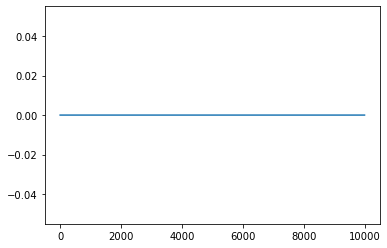

In [7]:
plt.plot(rho0)

In [8]:
first = np.zeros(len(Rho_mem))
for i in range(len(Rho_mem)):
    first[i]=find_first(Rho_mem[i]>1) 

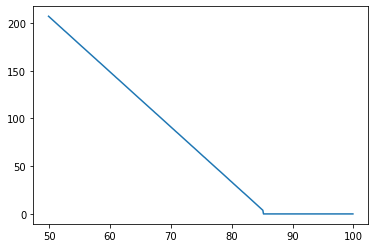

In [9]:
plt.plot(T_mem[500:],first[500:])

In [10]:
front_start = len(T_mem)//2

xfit = np.array(T_mem[front_start:])

yfit = np.array(first[front_start:])
filt = yfit > 50
xfit,yfit = xfit[filt],yfit[filt]
from scipy import stats
s_simu, intercept, r_value, p_value, std_err = stats.linregress(xfit,yfit)

r= -0.9999997903650538
s_simu= -5.766847761022358


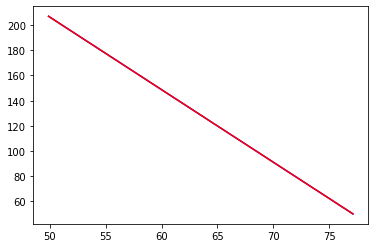

In [11]:

plt.plot(xfit,yfit,c='b')
plt.plot(xfit,intercept+s_simu*xfit, c='r')
print('r=', r_value)
print('s_simu=',s_simu)

In [12]:
def coeffs_P3():
    a = (lbda+f0)
    b = (f0**2+lbda*f0 -f0*F0)
    c = -F0*f0*(lbda+2*f0)
    d = (F0*f0)**2
    return [a,b,c,d]
def coeffs_Q():
    a,b,c,d = coeffs_P3()
    return [a, 2*b, 3*c, 4*d]


In [13]:
# Vitesse theorique Laurent
# def vitesse_theorique(sign=-1):
#     y = np.min( np.roots(coeffs_Q()))
#     p3_y = np.polyval(coeffs_P3(),y)
#     s_sel = sign*np.sqrt(-Temp*(y**4)/p3_y)
#     return s_sel

def vitesse_theorique(epsilon= .001,sign=-1):
    roots_Q = np.roots(coeffs_Q())
    candidats = [sign*1000*np.sqrt(Temp)]
    for x in roots_Q :
        p3_x = np.polyval(coeffs_P3(),x)
        if p3_x < 0:
            candidats += [sign*np.sqrt(-Temp*x**4/p3_x)]
    filtre = []
    for s in candidats:
        s_roots = np.roots([1]+[(s+sign*epsilon)**2*x for x in coeffs_P3()])
        s_roots = s_roots[np.isreal(s_roots)]
        if len(s_roots) == 4:
            filtre += [s]
    if sign == 1:
        s_theorique = np.min(filtre)
    else:
        s_theorique = np.max(filtre)
    return s_theorique

In [14]:
s_sel=vitesse_theorique(sign=1)
print(np.abs(s_simu+s_sel))

0.06432891610068037


In [15]:
for y in np.roots(coeffs_Q()):
    p3_y = np.polyval(coeffs_P3(),y)
    s_t = np.sqrt(-Temp*y**4/p3_y)
    print(s_t)

5.702518844921678
nan
13.582080648189462


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
def plot_roots():
    X =[]
    for n in np.linspace(0,50,10000):
        s = n/2
        roots = np.roots([1]+[s**2*x/Temp for x in coeffs_P3()])
        roots = roots[np.isreal(roots)]
        for i in range(len(roots)):
            X+=[[s,roots[i]]]

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    S = []
    Root = []
    for i in range(len(X)):
        S += [X[i][0]]
        Root += [X[i][1]]
    plt.figsize=(3,3)
   # plt.axis((-20,1,0,2*vitesse_theorique(sign=1)))
    plt.scatter(Root,S, marker='.')
    plt.axhline(y=vitesse_theorique(sign=1))

/usr/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


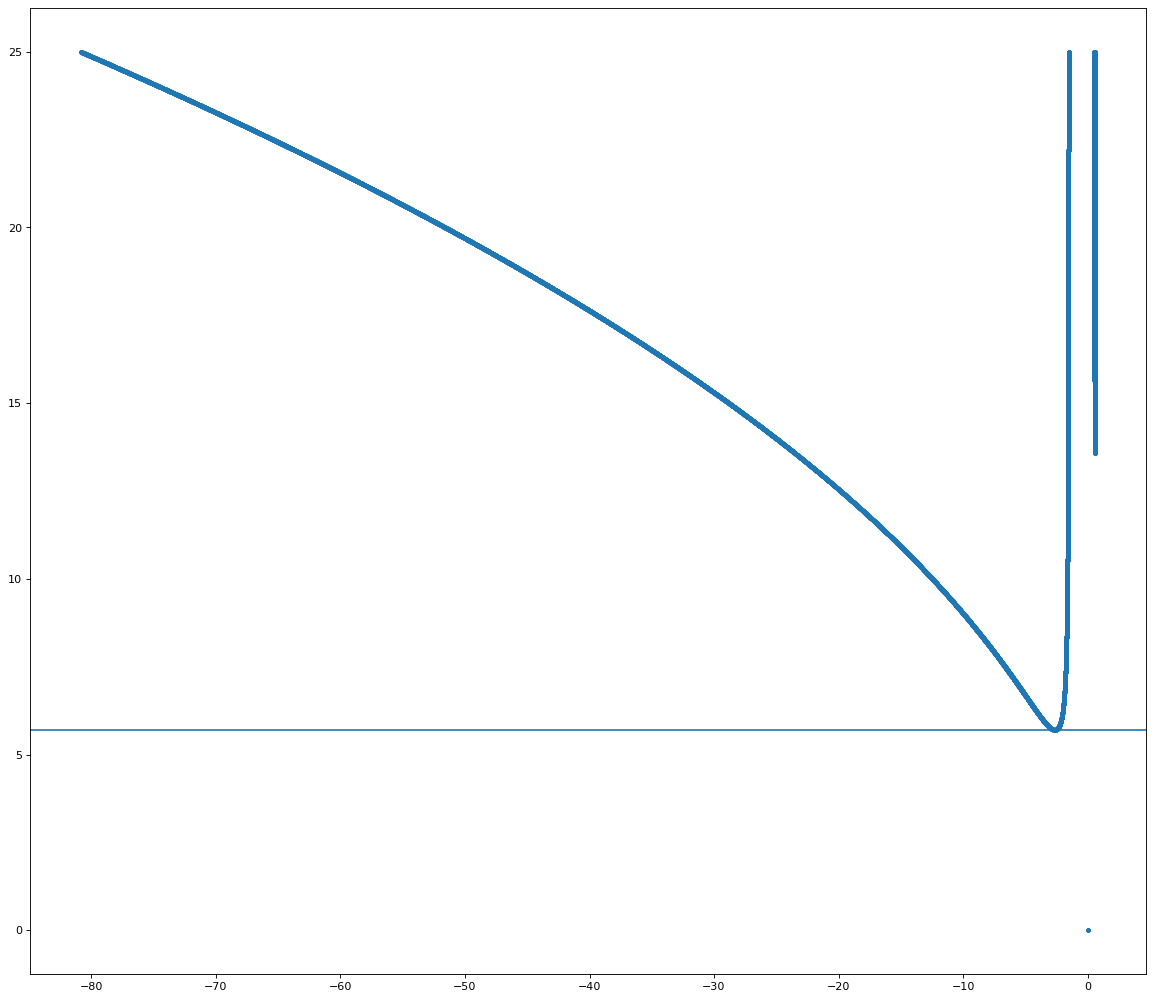

In [25]:
plot_roots()

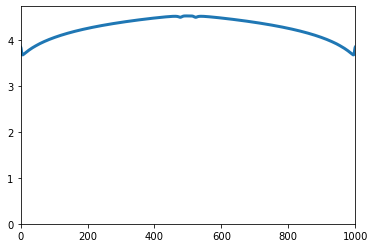

In [29]:
fig = plt.figure()
ax = plt.axes(xlim=(0, Lx), ylim=(0, Rho_mem[-1][Nx//2]+.2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(X,Rho_mem[20*i][:])
    return line,

ani = animation.FuncAnimation(fig, animate,init_func=init,frames= len(Mu_mem)//20, interval=50, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [19]:
s_simu

-5.766847761022358

In [20]:
s_sel

5.702518844921678

In [21]:
mu0[4999]

0.01

In [27]:
roots= np.roots([1]+[s_simu**2*x/Temp for x in coeffs_P3()])
len(roots[np.isreal(roots)])

2

In [31]:
roots= np.roots([1]+[(s_sel+.01)**2*x/Temp for x in coeffs_P3()])
len(roots[np.isreal(roots)])

2